# Dependências

In [ ]:
!pip install gensim

# Agrupamento de textos com K-Means

Neste notebook, usaremos o algoritmo k-means, um algoritmo simples e popular de agrupamento não-supervisionado, para agrupar letras de músicas de samba.

O objetivo do K-means é simples: agrupar pontos de dados semelhantes e descobrir padrões subjacentes. Para atingir esse objetivo, o K-means precisa de um número K de centróides em um conjunto de dados. Um centróide refere-se a um cluster, que é uma coleção de pontos de dados agregados devido a certas semelhanças entre si. As médias/means no K-means referem-se à média dos dados; isto é, encontrar o centróide. E o algoritmo é dito não supervisionado porque não temos conhecimento prévio sobre os grupos ou classes de nosso conjunto de dados, ou seja, encontraremos os grupos subjacentes em nosso conjunto de dados!

Abaixo podemos visualizar o algoritmo. Os centróides verdes correspondem aos pontos de dados mais próximos de cada um e formam clusters, então cada centróide se move para o centro de cada respectivo grupo e combina novamente os pontos de dados mais próximos entre si.

![alt text](https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Images/kmeans.gif?raw=true)

**Passos:**

__1.__ Explorar nossa coleção de músicas(corpus) <br>
__2.__ Aplicar engenharia de dados no conjunto de dados para obter o melhor desempenho do algoritmo K-means <br>
__3.__ Execute o algoritmo várias vezes, cada vez testando com um número diferente de clusters <br>
__4.__ Use diferentes métricas para visualizar nossos resultados e encontrar o melhor número de clusters (*ou seja, por que um total de X clusters é melhor do que um total de Y clusters?*) <br>
__5.__ Análise de cluster

**Métricas utilizadas para determinar o melhor número de K Cluters:**
- [Método do cotovelo](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import altair as alt

In [ ]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

from wordcloud import WordCloud
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Algumas Funções úteis

In [ ]:
def counting_words(df, predict, column):
  labels = np.unique(predict)
  couting = []
  for i in labels:
    mask = df[column] == i
    next_to_cluster = df[mask]
    a = next_to_cluster['clean_lyrics'].str.split()
    freq_word = []
    for i in a:
      freq_word = freq_word + i
    couting.append(nltk.FreqDist(freq_word))

  return couting

In [ ]:
def generate_word_clouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroids[i]
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title(f'Cluster {i}')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [ ]:
#Cálculo da PPMI
def compute_ppmi_smoothed(Xc, alpha=0.75):
    total = np.sum(Xc)
    sum_over_rows = np.sum(Xc, axis=1, keepdims=True)  # P(w)
    sum_over_cols = np.sum(Xc, axis=0, keepdims=True)  # P(c)

    # aplica suavização exponencial
    sum_over_rows_alpha = np.power(sum_over_rows, alpha)
    sum_over_cols_alpha = np.power(sum_over_cols, alpha)

    expected = sum_over_rows_alpha @ sum_over_cols_alpha / total
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2((Xc * total) / expected)
        pmi[np.isinf(pmi)] = 0.0
        pmi[np.isnan(pmi)] = 0.0
        pmi = np.maximum(pmi, 0)  # PPMI
    return pmi

## Analisando os dados

In [ ]:
# Carregando um dataset de letras de músicas
letras = pd.read_csv('https://github.com/nazareno/palavras-nas-letras/raw/master/letras-ptbr-sample.csv')
#Subamostrando devido restrições de memória do colab
letras = letras.sample(1000, random_state=42)
letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres
4489,Marrom Bombom + Meu Jeito de Ser + Coral de Anjos,A gente tem tudo. Pra dar certo. Fica comigo!....,Thiaguinho,143,13.8,Samba,Pagode; Romântico; Samba; Trilha Sonora; Black...
3739,Love Song,Fui atraído daqueles tipo amor bandido. Devido...,Pollo,53,3.5,Hip Hop,Hip Hop; Rap; Romântico; Pop; Pop/Rock; Funk; ...
1941,Na Pontinha (Part. Mc Menininho),Vai sentar. Vai se acabar. Na pontinha do garo...,Jerry Smith,19,2.1,Funk Carioca,Funk Carioca
2218,Recomeço (Lerina),Não vou mais tentar esconder. Dessa vez prefir...,KLB,129,2.5,Pop,Pop; Romântico; Pop/Rock; Rock; Trilha Sonora;...
626,Pra Baixo do Umbigo,Quando eu escuto o som de uma acordeona. Dentr...,Cezar & Paulinho,310,2.0,Sertanejo,Sertanejo
1675,Amor de Copo,Antes de você aparecer. Tudo parece tão perdid...,Henrique e Juliano,187,27.9,Sertanejo,Sertanejo; Romântico; Axé; Funk Carioca; Funk;...
1554,Zé Meningite,Revelação - Zé Meningite. . Zé meningite. Já t...,Grupo Revelação,188,13.0,Samba,Pagode; Samba; Romântico; Sertanejo; Samba Enr...
2576,Um Gênio,"Um gênio não se faz em um mês,histórias pra co...",Mag,63,2.3,Hip Hop,Hip Hop; Rap; Black Music; Funk; Pagode; Român...
577,1º de Julho,"Eu vejo o que aprendi,. O quanto te ensinei. E...",Cássia Eller,141,7.5,Rock,Rock; MPB; Pop/Rock; Pop; Romântico; Samba; Co...
179,Se Tudo Acaba,Quero ter você. Por perto. Desperto ao teu amo...,Anavitória,43,23.8,Pop,Indie; Pop; Folk; MPB; Romântico; Sertanejo; B...


In [ ]:
#Informações das colunas do nosso dataframe
print(letras.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4656 to 1128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SName       1000 non-null   object 
 1   Lyric       1000 non-null   object 
 2   Artist      1000 non-null   object 
 3   Songs       1000 non-null   int64  
 4   Popularity  1000 non-null   float64
 5   Genre       1000 non-null   object 
 6   Genres      1000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 62.5+ KB
None


In [ ]:
#Artistas mais presentes nesse sample
letras['Artist'].value_counts()[0:20]

,count
Artist,
Gian & Giovani,10
Paulo Ricardo,10
Kleiton e Kledir,8
Hungria,8
Gabriel O Pensador,8
Ultraje A Rigor,8
RPM,8
Claudinho & Buchecha,8
Projota,7


## Pré processamento do texto

In [ ]:
sw = stopwords.words('portuguese')
personalizadas = ['pra', 'mim', 'vou', 'vai', 'vem', 'tão','tudo','quer']
sw = sw + personalizadas
clean_lyrics = []

for lyric in letras['Lyric']:
    # Remove caracteres especiais e dígitos
    lyric = re.sub(r"(\d|\W|_)+|\w*\d\w*", " ", lyric)

    # Divide em palavras
    words = lyric.lower().split()

    # Remove stopwords e palavras curtas ou com números
    words = [w for w in words if w not in sw and len(w) > 2 and not any(c.isdigit() for c in w)]

    # Junta de volta
    cleaned = ' '.join(words)
    clean_lyrics.append(cleaned)

clean_lyrics[:10]

['louco hein filha quanta energia pede todo dia toda forma academia queria judia deve vício terapia relaxar terminar mente vez vez faz dez minutos gente parou calor quanto amor pede ver feliz além parar passar madrugada querendo hora hora preparar porque brincar pouquinho continua pouquinho continua hora parar louco hein filha quanta energia pede todo dia toda forma academia queria judia deve vício terapia relaxar terminar mente vez',
 'sei muitos hoje dia vivem vidas fio olhos fecham continuam acordados escuridão noite parece ter fim vida passageiro sorriso festim sei vida fácil dias sinto assim fortalece prosseguir irmão clame vida dentro pois clamar joelhos prostrar consolo chegará nova vida viverá medo cessará pois cristo irá reinar habita irá sentir sei muitos hoje dia vivem vidas fio olhos fecham continuam acordados escuridão noite parece ter fim vida passageiro sorriso festim sei vida fácil dias sinto assim irmão clame vida dentro pois clamar joelhos prostrar consolo chegará nov

In [ ]:
#Adicionando as letras preprocessadas no dataframe original
letras['clean_lyrics'] = clean_lyrics

#Liberando memória
del clean_lyrics

In [ ]:
letras

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics
4656,Tá Louco Hein,"Ta louco, hein filha!. Quanta energia, pede to...",Turma do Pagode,182,11.7,Samba,Romântico; Pagode; Samba; Sertanejo; Funk Cari...,louco hein filha quanta energia pede todo dia ...
3659,Nova Vida,Eu sei que muitos hoje em dia. Vivem suas vida...,PG,111,1.1,Rock,Rock; Gospel/Religioso; Pop/Rock; Funk; Clássi...,sei muitos hoje dia vivem vidas fio olhos fech...
907,Quem Sou Eu,Certas coisas sei que nunca vão mudar. Se eu t...,CPM 22,114,3.2,Rock,Hardcore; Punk Rock; Rock; Pop/Rock; Hard Rock...,certas coisas sei nunca vão mudar todas respos...
4352,Puro Diamante,Com ela é que não pago pra sonhar. Não vivo de...,Strike,49,1.3,Rock,Pop/Punk; Rock; Pop/Rock; Rock Alternativo; Pu...,pago sonhar vivo ilusão existe raro milhão tem...
3271,Fulminante,Eu amei. Nem sempre se calcula o risco mesmo a...,Mumuzinho,71,4.3,Samba,Pagode; Romântico; Samba; MPB; Sertanejo; Gosp...,amei sempre calcula risco assim amei desperdic...
...,...,...,...,...,...,...,...,...
3588,Só Me Fez Bem,Não sei se foi um mal/ não sei se foi um bem/....,Paulo Ricardo,143,2.2,Pop,Pop; Romântico; Pop/Rock; Rock; MPB; Trilha So...,sei mal sei bem sei fez bem coração sofri sofr...
679,Minha Embaixada Chegou,Minha embaixada chegou. Deixa meu povo passar....,Chico Buarque,447,14.1,Samba,Bossa Nova; Samba; MPB; Romântico; Samba Enred...,embaixada chegou deixa povo passar povo pede l...
3998,Natalício,Brilha em cima do rancho. Uma estrela a luz e ...,Renato Teixeira,203,1.1,Sertanejo,Regional; Sertanejo; MPB; Folk; Axé,brilha cima rancho estrela luz dia todo menino...
2706,Passarinho Fofoqueiro,Se um passarinho fofoqueiro aparecer aí. Dizen...,Marcos e Belutti,143,5.6,Sertanejo,Sertanejo; Romântico; Trilha Sonora; Country; ...,passarinho fofoqueiro aparecer dizendo uns abs...


## Vetores TF-IDF
Nesta etapa, as músicas são vetorizadas aplicando TFIDF. Ainda não está sendo empregado a estratégia de buscar os embeddings das palavras e transformar as sentenças em um vetor com base nos vetores de suas palavras.

In [ ]:
tfv = TfidfVectorizer(
        min_df = 10,
        max_df = 0.5,
        max_features = None,
        stop_words = sw
  )

vec_text = tfv.fit_transform(letras['clean_lyrics'])

words = tfv.get_feature_names_out()

len(words)

1127

In [ ]:
words[1:10]

array(['abraçar', 'abraço', 'abre', 'abrigo', 'abrir', 'acaba', 'acabar',
       'acabou', 'aceita'], dtype=object)

## Agrupando com o K-Means

Para simplificar o trabalho, vamos escolher **4 grupos**. Ou seja, vamos tentar identificar quais músicas são mais parecidas entre si, considerando apenas 4 grupos distintos.

PS: existem métodos específicos para tentar definir um melhor k com base nos próprios dados.

In [ ]:
k = 4

In [ ]:
#Nesta etapa, um objeto da classe kmeans é instanciado e executamos o algoritmo considerando cada música vetorizada por tfidf
kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
kmeans.fit(vec_text)
labels_tfidf = kmeans.predict(vec_text)

#Criando um novo dataframe
letras['tfidf_group'] = labels_tfidf

letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics,tfidf_group
3143,Prosperidade e Lealdade,Prosperidade e lealdade aos braço forte. Acele...,Mc Neguinho do Kaxeta,41,2.8,Funk Carioca,Funk Carioca; Funk; World Music; Gospel/Religioso,prosperidade lealdade braço forte acelera pisa...,1
1361,No Calor Dos Salões,"Hoje é o grande dia,. vamos todos festejar,. e...",Fundo de Quintal,315,4.6,Samba,Samba; Pagode; Velha Guarda; Romântico; Axé; S...,hoje grande dia vamos todos festejar união faz...,1
642,Quando Eu Espero Você,Quando eu espero você. É difícil viver. Contro...,Cezar & Paulinho,310,2.0,Sertanejo,Sertanejo,espero difícil viver controlar emoção coração ...,1
3806,Amor E Desejos,Foi tão dificil. Encontrar você. Que muito que...,Raça Negra,280,14.3,Samba,Romântico; Samba; Pagode; Axé; MPB; Regional; ...,dificil encontrar queria quis perder fez poder...,1
2244,Bem Melhor,"E eu, que nunca fui exemplo de calma. Agora eu...",Lagum,17,3.8,Rock,Rock; Surf Music; Pop/Rock,nunca exemplo calma agora bem melhor fica memó...,2
4263,Como Nós Somos Unidos,Sandy eu tive uma idéia que você vai adorar. U...,Sandy & Junior,201,14.0,Pop,Pop,sandy idéia adorar nova brincadeira pegar unid...,2
4141,"Vermelho, A Cor do Amor",Verde é a cor da primavera. Faz tudo renascer....,Rouge,73,2.4,Pop,Romântico; Pop; Dance; Pop/Rock; Soul Music; B...,verde cor primavera faz renascer vida dia enco...,1
3778,Cobertor,Eu sei que o tempo pode afastar a gente. Mas s...,Projota,138,15.7,Hip Hop,Hip Hop; Rap; Romântico; Funk; Pop; Reggae; Bl...,sei tempo pode afastar gente tempo afastar gen...,2
184,Tá na Mira,Não sou de falar mas me peguei pensando em voc...,Anitta,104,40.1,Pop,Pop; Dance; Funk Carioca; Axé; Electro Swing; ...,falar peguei pensando presta muita atenção diz...,2
1702,Hoje Eu Te Amo,hoje eu acordei pensando em você.. querendo ve...,Hugo Pena e Gabriel,115,1.7,Sertanejo,Romântico; Sertanejo; Country; Trilha Sonora; ...,hoje acordei pensando querendo ver brilho olho...,1


In [ ]:
#Verificando a quantidade de letras atribuídas a cada grupo
letras['tfidf_group'].value_counts()

,count
tfidf_group,
2,461
1,362
0,133
3,44


In [ ]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('tfidf_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')


-----
GRUPO 0:
Artist
Hungria                     4
Pedra Letícia               3
Marcelo D2                  3
Racionais Mc's              3
Ao Cubo                     3
Tião Carreiro e Pardinho    3
Frejat                      3
Karol Conka                 3
Titãs                       3
Velhas Virgens              3
Name: count, dtype: int64
-----

-----
GRUPO 1:
Artist
Gian & Giovani         7
Di Paullo e Paulino    6
Edson e Hudson         6
Kleiton e Kledir       5
Alexandre Pires        5
Paulo Ricardo          5
Diogo Nogueira         4
RPM                    4
Teodoro e Sampaio      4
Tonico e Tinoco        4
Name: count, dtype: int64
-----

-----
GRUPO 2:
Artist
Gabriel O Pensador      7
Kelly Key               6
Ultraje A Rigor         6
Barão Vermelho          6
Cazuza                  5
Projota                 5
Arlindo Cruz            5
Claudinho & Buchecha    5
Marcos e Belutti        5
Anitta                  5
Name: count, dtype: int64
-----

-----
GRUPO 3:
Artist
PG

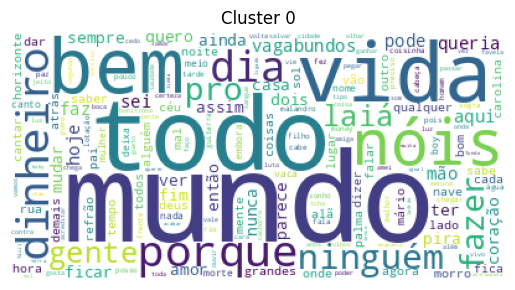

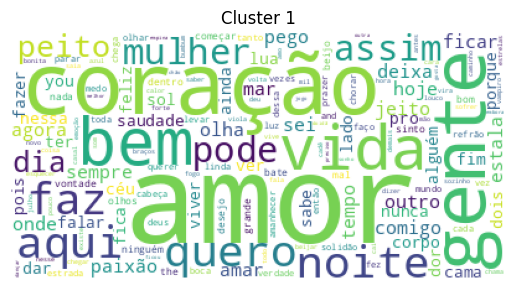

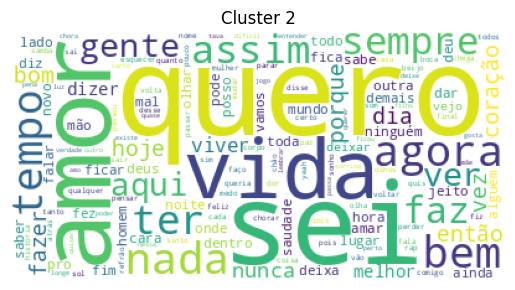

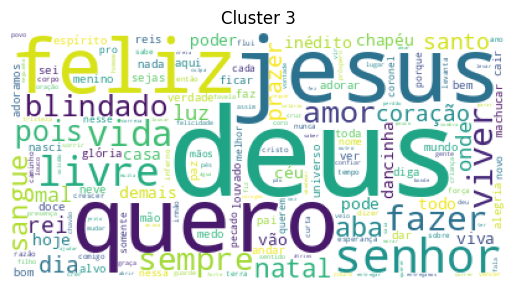

In [ ]:
# Exibindo as palavras mais comuns e cada grupo
generate_word_clouds(counting_words(letras,labels_tfidf, 'tfidf_group'))

In [ ]:
#Exibindo alguns regristo de um certo grupo
#Escolha um grupo e analise os artistas, letras e gêneros

pd.options.display.max_colwidth = 100
letras.query('tfidf_group == 2')[['SName', 'Lyric', 'Artist', 'Genre']].sample(10)

,SName,Lyric,Artist,Genre
4607,Sem Rótulo,"Viaja não ""fí"".. Sente essa parada. Duckjay. Sugestão pra ser o vilão e não me interessa. Cicatr...",Tribo da Periferia,Hip Hop
2468,Interrogações,"O seu olhar no meu olhar. O que você vê é o mesmo. Que eu tento enxergar. Pra nós dois, nada alé...",Lucas Lucco,Sertanejo
4113,Sincera Comigo,"Sincera comigo. Eu sei... Se você não está feliz. Diga pra mim. É bem pior mentir, isso é o fim....",Rodriguinho,Samba
4017,A Força do Amor,Abriu minha visão o jeito do amor. Tocando o pé no chão alcança as estrelas. Tem poder de mover ...,Rick & Renner,Sertanejo
3455,Cadê a Paz,"Cadê a paz,. será que ela fugiu?. ou será também que nunca existiu,. pode ter sido morta pela gu...",Oriente,Hip Hop
3590,Por Amor,Paulo Ricardo - Por Amor. . Eu ouvi. Dizer que você falou. Que está pensando em voltar para mim....,Paulo Ricardo,Pop
3214,Se Quer a Verdade,Eu me lembro de tudo. Eu sei porque eu te perdi. Eu tô saindo pra te procurar. Pra te procurar.....,Michel Teló,Sertanejo
61,Primo do Jazz,Meu samba tem um nhenhenhen. Que pouca gente já sacou. Meu samba faz pandant com jazz. Do jeito ...,Alcione,Samba
2369,São Tomé,Eu vou pegar o carro. passar a noite na estrada. Parar num bar pr'um café. Lavar o rosto e segui...,Leoni,Rock
3624,Profundezas,Mergulhei nas profundezas desse mundo de ilusão. Fui mais além do que suporta o coração. Ultrapa...,Péricles,Samba


## PPMI (Positive Pontual Multiwise Individual)

Agora vamos trabalhar com um método diferente de vetorização. Vamos calcular o PPMI de cada palavra e depois transformar as letras utilizando os embeddings de cada palavra em cada letra.


1. Utilize um vetorizador para contar cada palavra (bag-of-words) da coluna clean_lyrics do dataframe. Salve o resultado da vetorização na variável X

In [ ]:
#Seu código aqui

In [ ]:
#Essa etapa está pronta, não é necessário mudá-la. Aqui estamos gerando a matriz de co-ocorrência das palavras
Xc = (X.T @ X).toarray()  # coocorrência entre palavras

2. Invoque a função compute_ppmi_smoothed para calcular o PPMi de cada palavra. Você pode fazer isso passando a variável Xc como argumento do método. Salve o resultado na variável ppmi_matrix

In [ ]:
#Seu código aqui

3. Crie um dataframe chamado ppmi_df. Para essa criação você precisa da variável ppmi_matrix e do nome de cada coluna. Os nomes podem ser obtidos utilizando o vetorizador criado anteriormente e invocando o método get_features_names_out(). A criação pode ser feita utilizando o método pd.Dataframe(seu_dados, index=suas_palavras, columns=suas_palavras)

In [ ]:
#Seu código aqui

ppmi_df.head()

In [ ]:
#Esse trecho não precisa ser alterado. Estamos apenas liberando espaço na memória
del ppmi_matrix

4. Complete o método abaixo para que ele seja capaz de transformar cada letra das músicas em sua forma vetorizada utilizando os embeddigns das palavras do dataframe ppmi_df.

In [ ]:
#Esse método está parcialmente implementado
def lyric_embeddings_from_ppmi(df, text_column, ppmi_df):

    #Essa variável irá salvar os embeddings de cada letra
    embeddings = []
    words_in_vocab = set(ppmi_df.index)

    for lyric in df[text_column]:

        #1. Para cada letra do dataframe, primeiro separe as palavras pelo espaço

        #2. Para cada palavra que foi separada por espaço, busque no dataframe ppmi_df seu embedding e salve-a em um vetor auxiliar
        # Você pode fazer buscar um embedding de uma palavra usando o método .loc[sua_palavra].values do dataframe ppmi_df
        # Lembre que, para cada embedding, você precisa adicioná-lo ao vetor temporário.


        #3. Calcule a média de todos os embeddings salvos no vetor temporário da etapa anterior
        # Você pode fazer isso utilizado a o método np.mean(seu_vetor_de_vetores, axis=0) e salvando o resultado na variável lyric_vector


        #4. Salvando o embedding de cada letra, ou seja, a versão vetorizada da letra.
        embeddings.append(lyric_vector)

    # Criando um novo DataFrame com as representações e retornando-a
    embedding_df = pd.DataFrame(embeddings, index=df.index)
    return embedding_df

In [ ]:
# Essa etapa já está pronta, não é necessário mudá-la. Aqui, passamos nosso dataframe de letras e recebemos um dataframe de embeddings
ppmi_embeddings_df = lyric_embeddings_from_ppmi(letras, 'clean_lyrics', ppmi_df)
ppmi_embeddings_df.head()

5. Agora, vamos executar o Kmeans como nosso dataframe ppmi_embeddings_df. Você pode ver o exemplo de uso do KMeans na Seção Inicial deste notebook.

- Use k = 4
- Crie um novo objeto do tipo MiniBatchKMeans
- Salve as classificações na variável labels_pmi
- Faça uma nova coluna no dataframe letras (letras['pmi_group']) e atribua labels_pmi

In [ ]:
#Seu código aqui

letras.sample(10)

6. A partir daqui, não é necessário nenhuma implementação. Apenas execute as células para realizar análises sobre os resultados.

In [ ]:
#Verificando a quantidade de letras por grupo.
letras['pmi_group'].value_counts()

In [ ]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('pmi_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')

In [ ]:
generate_word_clouds(counting_words(letras,labels_pmi, 'pmi_group'))

In [ ]:
#Exibindo alguns regristo de um certo grupo
#Escolha um grupo e analise os artistas, letras e gêneros

pd.options.display.max_colwidth = 100
letras.query('pmi_group == 3')[['SName', 'Lyric', 'Artist', 'Genre']].sample(10)

## Perguntas sobre o PMI

Responda cada perguntando apresentando uma justificativa

1. Considerando os artistas de cada grupo, é possível verificar alguma conexão entre eles? (Ex: gênero, estilo de música, temas abordados)

2. Considerando as nuvens de palavras de cada grupo, argumente se existe um grupo bem definido ou se não existe uma definição clara sobre que tipo de música (tema) cada grupo tem.

3. De maneira geral, você acha que os resultados do PPMI são mais consistentes que os do TFIDF?

# Word2Vec

Agora vamos trabalhar com o Word2Vec. Primeiramente vamos treinar os embeddings considerando todas as letras do nosso dataset. Em seguida, vamos vetorizar essas letras utilizando os embeddings das palavras de cada letra. Em seguida, vamos aplicar o KMeans e analisar os grupos.

1. Inicialmente, precisamos quebrar cada letra do nosso dataset em uma lista de palavras. Isso deve ser feito para cada letra. O resultado deve ser um vetor de vetores, em que cada subvetor é o conjunto de palavras da letra atual. Lembre-se que você deve considerar as letras que estão na coluna 'clean_lyric' do dataframe.

In [ ]:
#Seu código aqui

2. Chame a classe Word2Vec() passando para ela o vetor de letras que estão separadas por espaço. Além disso, utilize os seguintes parâmetros:

- vector_size=100,  # tamanho dos vetores
- window=5,
- min_count=2,
- workers=4,
- epochs=15,
- sg=1


- Salve o modelo na variável w2v_model

In [ ]:
# Treina o modelo Word2Vec
# Seu código aqui

w2v_model.wv['amor']

3. Complete o método abaixo para que ele seja capaz de transformar cada letra das músicas em sua forma vetorizada utilizando os embeddigns das palavras que você pode obter do modelo w2v_model.

In [ ]:
#Este método está parcialmente completo. Ele tem algumas similaridades com o método de
def lyric_embeddings_from_w2v(df, text_column, w2v_model):

    #Aqui será armazenando o embedding final de cada letra.
    embeddings = []
    vocab = w2v_model.wv.key_to_index

    for lyric in df[text_column]:

        #1. Para cada letra do dataframe, primeiro separe as palavras pelo espaço


        #2. Para cada palavra que foi separada por espaço, busque no w2v_model seu embedding e salve-a em um vetor auxiliar
        # Você pode fazer buscar um embedding de uma palavra usando o método w2v_model.wv[sua_palavra]
        # Lembre que, para cada embedding, você precisa adicioná-lo ao vetor temporário.


        #3. Calcule a média de todos os embeddings salvos no vetor temporário da etapa anterior
        # Você pode fazer isso utilizado a o método np.mean(seu_vetor_de_vetores, axis=0) e salvando o resultado na variável lyric_vector


        #4. Salvando o embedding de cada letra, ou seja, a versão vetorizada da letra.
        embeddings.append(lyric_vector)

    # Cria um DataFrame com os embeddings
    embedding_df = pd.DataFrame(embeddings, index=df.index)
    return embedding_df

In [ ]:
# Esta parte está pronta, não é necessário alterá-la
w2v_embeddings_df = lyric_embeddings_from_w2v(letras, 'clean_lyrics', w2v_model)
w2v_embeddings_df.head()

4. Agora, vamos executar o Kmeans como nosso dataframe w2v_embeddings_df. Você pode ver o exemplo de uso do KMeans na Seção Inicial deste notebook.
- Use k = 4
- Crie um novo objeto do tipo MiniBatchKMeans()
- Salve as classificações na variável labels_w2v
- Faça uma nova coluna no dataframe letras (letras['w2v_group']) e atribua labels_w2v

In [ ]:
#Seu código aqui

letras.sample(10)

5. A partir daqui, não é necessário nenhuma implementação. Apenas execute as células para realizar análises sobre os resultados.

In [ ]:
#Verificando a quantidade de letras por grupo.
letras['w2v_group'].value_counts()

In [ ]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('w2v_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')

In [ ]:
generate_word_clouds(counting_words(letras,labels_w2v, 'w2v_group'))

## Perguntas sobre o Word2Vec
Responda cada perguntando apresentando uma justificativa

1. Considerando os artistas de cada grupo, é possível verificar alguma conexão entre eles? (Ex: gênero, estilo de música, temas abordados)

2. Considerando as nuvens de palavras de cada grupo, argumente se existe um grupo bem definido ou se não existe uma definição clara sobre que tipo de música (tema) cada grupo tem.

3. De maneira geral, você acha que os resultados com o Word2Vec são mais consistentes que os dos métodos anteriores?